In [1]:
import geoopt as g
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from hierarchy_transformers import HierarchyTransformer
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments, EvalPrediction


In [2]:
# semantic text similarity
sts_b = load_dataset("glue", "stsb")

In [3]:
# tokenizer for the model
tokenizer_HiT = AutoTokenizer.from_pretrained("Hierarchy-Transformers/HiT-MiniLM-L12-WordNetNoun")
tokenizer_allMini = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L12-v2")

In [4]:
# Tokenize the datasets

def process_samples(samples, tokenizer):
    # Tokenize the text via the tokenizer
    return tokenizer(samples["sentence1"], samples["sentence2"], padding=True, truncation=True, return_tensors="pt")

sts_b_HT = sts_b.map(lambda x: process_samples(x, tokenizer_HiT), batched=True)
sts_b_LM = sts_b.map(lambda x: process_samples(x, tokenizer_allMini), batched=True)

Map:   0%|          | 0/1379 [00:00<?, ? examples/s]

Map:   0%|          | 0/1379 [00:00<?, ? examples/s]

In [5]:
# Convert to PyTorch tensors

def format_to_torch(dataset, label_key): 
    dataset = dataset.remove_columns(["idx"])
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', label_key])
    return dataset

def normalize_labels(example):
	example['label'] = example['label'] / 5.0
	return example

In [6]:
sts_b_LM_formatted = format_to_torch(sts_b_LM['validation'], "label").map(normalize_labels)
sts_b_HT_formatted = format_to_torch(sts_b_HT['validation'], "label").map(normalize_labels)

In [7]:
# Load the models

hit = HierarchyTransformer.from_pretrained("Hierarchy-Transformers/HiT-MiniLM-L12-WordNetNoun")
elm = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L12-v2")

In [8]:
elm.to('mps')
hit.to('mps')

HierarchyTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [ ]:
def compute_metrics(evaluation_prediction):
    logits, labels = evaluation_prediction
    predictions = np.argmax(logits, axis=1) # classification
    accuracy = np.mean(predictions == labels)
    return {"accuracy": accuracy}


In [11]:
from torch.utils.data import DataLoader
import numpy as np
from sentence_transformers import SentenceTransformer

def evaluate_model(model, dataset, batch_size=16, is_regression=False):
    """
    Evaluate a SentenceTransformer model on a dataset.
    - `is_regression`: Set to True for STS-B where labels are continuous scores.
    """
    dataloader = DataLoader(dataset, batch_size=batch_size)

    model.eval()
    device = torch.device("mps" if torch.mps.is_available() else "cpu")
    model.to(device)

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            sentences1 = batch["sentence1"]
            sentences2 = batch["sentence2"]
            labels = batch["labels"].numpy()  # Extract labels

            # Compute sentence embeddings
            embeddings1 = model.encode(sentences1, convert_to_tensor=True)
            embeddings2 = model.encode(sentences2, convert_to_tensor=True)

            # Compute cosine similarity
            similarity_scores = torch.nn.functional.cosine_similarity(embeddings1, embeddings2).cpu().numpy()

            all_predictions.extend(similarity_scores)
            all_labels.extend(labels)

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Compute evaluation metric
    if is_regression:  # STS-B task (regression)
        from scipy.stats import pearsonr
        metric = {"pearson_correlation": pearsonr(all_predictions, all_labels)[0]}
    else:  # Classification task (SNLI, QQP)
        predictions = (all_predictions > 0.5).astype(int)  # Binary classification threshold
        accuracy = np.mean(predictions == all_labels)
        metric = {"accuracy": accuracy}

    return metric

In [58]:
from sentence_transformers import SentenceTransformer

# Convert dataset to proper format
def prepare_sentence_transformer_dataset(dataset):
    return [{"sentence1": s1, "sentence2": s2, "labels": label} 
            for s1, s2, label in zip(dataset["sentence1"], dataset["sentence2"], dataset["label"])]

# Prepare datasets
sts_b_HT_data = prepare_sentence_transformer_dataset(sts_b_HT_formatted)
sts_b_LM_data = prepare_sentence_transformer_dataset(sts_b_LM_formatted)

# Load SentenceTransformer models
hit_model = SentenceTransformer("Hierarchy-Transformers/HiT-MiniLM-L12-WordNetNoun")
elm_model = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2")

# Evaluate models
print("Hyperbolic Model Performance:")
print("STS-B:", evaluate_model(hit_model, sts_b_HT_data, is_regression=True))

print("\nEuclidean Model Performance:")
print("STS-B:", evaluate_model(elm_model, sts_b_LM_data, is_regression=True))


Hyperbolic Model Performance:
STS-B: {'pearson_correlation': np.float32(0.7610812)}

Euclidean Model Performance:
STS-B: {'pearson_correlation': np.float32(0.87691057)}


In [75]:
def get_embeddings(model, dataset, layer=-1, batch_size=16):

    model.eval()
    device = torch.device("mps" if torch.mps.is_available() else "cpu")
    model.to(device)

    dataloader = DataLoader(dataset, batch_size=batch_size)

    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            sentences1 = batch["sentence1"]
            sentences2 = batch["sentence2"]
            labels = batch["labels"].numpy()

            embeddings1 = model.encode(sentences1, convert_to_tensor=True, layer=layer)
            embeddings2 = model.encode(sentences2, convert_to_tensor=True, layer=layer) 
    
            all_embeddings.extend(embeddings1.cpu().numpy())
            all_embeddings.extend(embeddings2.cpu().numpy())
            all_labels.extend(labels)


    
    return all_embeddings, all_labels

In [90]:
hit_embeddings, hit_labels = get_embeddings(hit_model, sts_b_HT_data, layer=-1)
elm_embedings, elm_labels = get_embeddings(elm_model, sts_b_LM_data, layer=-1)

In [91]:
doubled_labels = []
for i in hit_labels:
    doubled_labels.append(i)
    doubled_labels.append(i)
print(doubled_labels)


[np.float32(1.0), np.float32(1.0), np.float32(0.95), np.float32(0.95), np.float32(1.0), np.float32(1.0), np.float32(0.48000002), np.float32(0.48000002), np.float32(0.55), np.float32(0.55), np.float32(0.523), np.float32(0.523), np.float32(1.0), np.float32(1.0), np.float32(0.4666), np.float32(0.4666), np.float32(0.75), np.float32(0.75), np.float32(1.0), np.float32(1.0), np.float32(0.64), np.float32(0.64), np.float32(0.3166), np.float32(0.3166), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(0.98179996), np.float32(0.98179996), np.float32(0.16), np.float32(0.16), np.float32(0.48000002), np.float32(0.48000002), np.float32(1.0), np.float32(1.0), np.float32(0.8), np.float32(0.8), np.float32(0.12719999), np.float32(0.12719999), np.float32(0.6), np.float32(0.6), np.float32(0.3428), np.float32(0.3428), np.float32(0.64), np.float32(0.64), np.float32(0.4334), np.float32(0.4334), np.float32(0.2), np.float32(0.2), np.float32(0.38340002), np.float32(0.38340002), np.fl

In [92]:
len(hit_labels)

1500

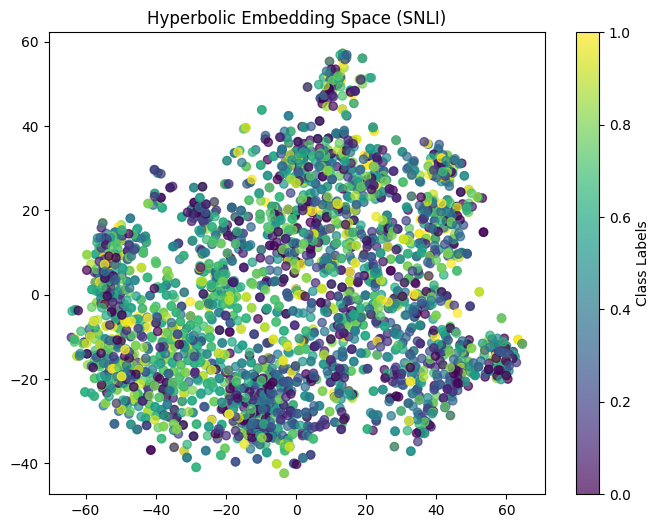

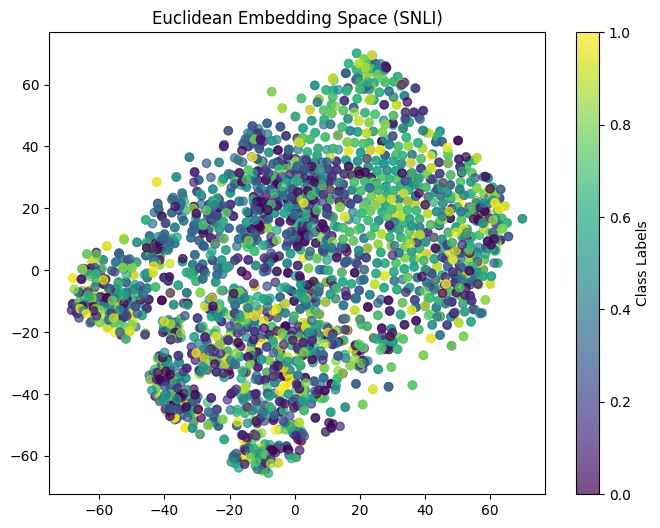

In [96]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(embeddings, labels, title="t-SNE Visualization"):
    tsne = TSNE(n_components=2, perplexity=50, random_state=42)
    reduced = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label="Class Labels")
    plt.title(title)
    plt.show()


plot_tsne(np.array(hit_embeddings), doubled_labels, title="Hyperbolic Embedding Space (SNLI)")
plot_tsne(np.array(elm_embedings), doubled_labels, title="Euclidean Embedding Space (SNLI)")